In [1]:
%load_ext nb_black

import sys, gzip, pickle

sys.path.append(".")
print(sys.version)

3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]


<IPython.core.display.Javascript object>

In [2]:
from run_inference import (
    Ex,
    Ex_t,
    Ey,
    Ey_t,
    T,
    advi_file,
    argparse,
    chi_clip,
    chi_obs,
    chi_ss,
    cobra,
    e,
    e_file,
    e_indexer,
    e_inds,
    e_laplace_inds,
    e_measured,
    e_unmeasured,
    e_zero_inds,
    emll,
    en,
    initialize_elasticity,
    ll,
    log_en_t,
    log_vn_obs,
    log_vn_ss,
    m_compartments,
    model,
    model_file,
    n_exp,
    n_iterations,
    np,
    os,
    pd,
    pm,
    pymc_model,
    r_compartments,
    r_labels,
    ref_state,
    rxn,
    to_consider,
    v,
    v_file,
    v_inds,
    v_star,
    v_star_file,
    vn,
    vn_ss,
    x,
    x_file,
    x_inds,
    xn,
    # yn,
    yn_t,
)

Using license file /Users/zuck016/gurobi.lic
Set parameter TokenServer to value leghorn.emsl.pnl.gov
N:  (171, 172) Ex:  (172, 171) Ey:  (172, 4) v_star:  (172,) vn:  (50, 172) v:  (172, 51)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


log(vn):  Shape.0 vn:  (50, 172)


/Users/zuck016/.pyenv/versions/anaconda3-2020.11/envs/idp_new/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/zuck016/.pyenv/versions/anaconda3-2020.11/envs/idp_new/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


<IPython.core.display.Javascript object>

In [3]:
with gzip.open('model.pz', 'wb') as f:
     pickle.dump(pymc_model, f)

with gzip.open('model_data.pz', 'wb') as f:
    pickle.dump({
        'model': model,
        'vn': vn,
        'en': en,
        #'yn': yn,
        'xn': xn,
        'x_inds': x_inds,
        'e_inds': e_inds,
        'v_inds': v_inds,
        #'m_labels': m_labels,
        'r_labels': r_labels,
        'll': ll,
        'v_star': v_star
    }
        , f)


<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", color_codes=True)

from tqdm import tqdm

%matplotlib inline

/Users/zuck016/.pyenv/versions/anaconda3-2020.11/envs/idp_new/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

load the previously stored approximation

In [5]:
import gzip
import pickle

with gzip.open("output_" + advi_file, "rb") as f:
    inference_data = pickle.load(f)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


<IPython.core.display.Javascript object>

In [10]:
trace, hist, approx = inference_data['trace'], inference_data['hist'], inference_data['approx']


<IPython.core.display.Javascript object>

## plot of ELBO convergence vs iteration

TODO:  Use previous ADVI inference as a "warm-start" to finish out at 40k

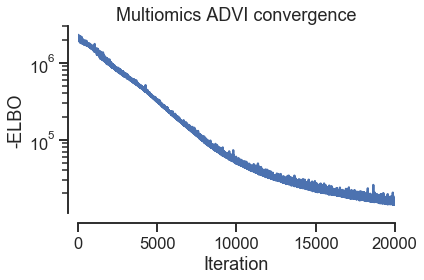

<IPython.core.display.Javascript object>

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.semilogy(hist.hist, "-", ms=1, rasterized=True)
ax.set_xlim([0, n_iterations])

sns.despine(offset=10)
ax.set_xlabel("Iteration")
ax.set_ylabel("-ELBO")
ax.set_title("Multiomics ADVI convergence")

plt.tight_layout()

plt.savefig(f"A.niger_{n_iterations:E}_advi.svg")

Sample the approximation to generate a 'trace' and posterior predictive distribution

In [21]:
with pymc_model:

    trace = approx.approx.sample(500)
    ppc = pm.sample_ppc(trace)

100%|██████████| 500/500 [29:14<00:00,  3.51s/it]


<IPython.core.display.Javascript object>

In [29]:
with gzip.open('output_' + advi_file, 'wb') as f:
        pickle.dump({'approx': approx,
         'hist': hist,
         'trace': trace}, f)


<IPython.core.display.Javascript object>

In [30]:
!ls

A.niger_2.000000E+04_advi.svg             __pycache__
A.niger_advi.pgz                          metabolite_concentrations.csv
A.niger_advi_20k.pgz                      normalized_line_rates.csv
A.niger_advi_30k.pgz                      normalized_targeted_enzyme_activities.csv
Bayespergillus.ipynb                      output_A.niger_advi_20k.pgz
Eflux2_flux_rates.csv                     run_inference.py
Eflux2_flux_rates.flipped.csv             run_inference.py~


<IPython.core.display.Javascript object>

In [12]:
def plot_hpd(ax, real, ppc, error=True, ms=3, alpha=0.5, color="b"):
    if error:
        ax.plot(
            np.vstack([real.values.flatten(), real.values.flatten()]),
            pm.hpd(ppc).reshape(-1, 2).T,
            color=color,
            lw=1,
            alpha=0.05,
            zorder=0,
        )
    ax.plot(real, np.median(ppc, 0), ".", ms=ms, color=color, alpha=alpha, zorder=0)

<IPython.core.display.Javascript object>

Metabolites are given in relative concentrations, which actually works perfectly for this analysis.

Specifically, the concentrations are given by $$x = A 2^a,$$ where $A$ is `Conversion_to_Absolute` and $a$ are the columns of `metabolites`.

For a given reference state $x^* = A 2^b,$ $$\chi = \log(\frac{x}{x^*}) = \log\left(\frac{A 2^a}{A 2^b}\right) = (a - b) \log 2$$

Therefore we can calculate values of $\chi$ even when absolute metabolite concentrations aren't known.
Enzymes are also reported as $\log_2$ transformed variables.
For $\hat{e}$, we need $$\frac{e}{e^*} = \frac{A 2^{y}}{A 2 ^{y^*}} = 2^{y - y^*}$$

In [8]:
e_inds

array([  1,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  30,  33,  36,
        42,  46,  47,  62,  66,  67,  69,  79, 153, 154, 155, 167])

<IPython.core.display.Javascript object>

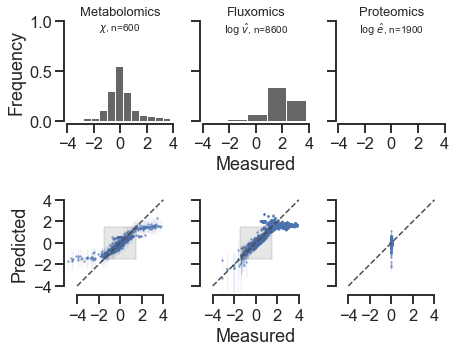

<IPython.core.display.Javascript object>

In [13]:
plt.rcParams["axes.axisbelow"] = False

fig, ax_matrix = plt.subplots(
    ncols=3, nrows=2, figsize=(6.5, 5), sharex="row", sharey="row"
)

for ax in ax_matrix[1, :].flatten():
    ax.set_aspect("equal")

_ = ax_matrix[0, 0].hist(
    xn.values.flatten(), bins=15, lw=1, edgecolor="w", density=True, facecolor=".4"
)
_ = ax_matrix[0, 1].hist(
    np.log(np.clip(vn.values.flatten(), 1e-8, 1e8)),
    bins=15,
    lw=1,
    edgecolor="w",
    density=True,
    facecolor=".4",
)
_ = ax_matrix[0, 2].hist(
    np.log(en.values.flatten()),
    bins=15,
    lw=1,
    edgecolor="w",
    density=True,
    facecolor=".4",
)

plot_hpd(ax_matrix[1, 0], xn, trace["chi_ss"][:, :, x_inds])
plot_hpd(
    ax_matrix[1, 1],
    np.log(vn),
    np.log(np.clip(trace["vn_ss"][:, :, v_inds], 1e-8, 1e8)),
)
plot_hpd(ax_matrix[1, 2], np.log(en), trace["log_en_t"][:, :, e_inds])
# plot_hpd(ax_matrix[1, 2], np.log(en), trace["log_en_t"][:, :, e_inds])
for ax in ax_matrix[1, :]:
    ax.set_rasterization_zorder(1)

ax_matrix[1, 0].set_xlim([-4, 4])
ax_matrix[1, 1].set_xlim([-4, 4])
ax_matrix[1, 2].set_xlim([-4, 4])
ax_matrix[1, 0].set_ylim([-4, 4])
ax_matrix[1, 1].set_ylim([-4, 4])
ax_matrix[1, 2].set_ylim([-4, 4])

for ax in ax_matrix[0, :]:
    ax.set_xlim([-4, 4])
    ax.set_xticks([-4, -2, 0, 2, 4])

for ax in ax_matrix[1, :]:
    ax.plot([-4, 4], [-4, 4], "--", color=".3", zorder=4, lw=1.5)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-4, -2, 0, 2, 4])


ax_matrix[1, 0].fill_between(
    [-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5], zorder=4, color="k", alpha=0.1
)
ax_matrix[1, 1].fill_between(
    [-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5], zorder=4, color="k", alpha=0.1
)

ax_matrix[0, 0].set_ylim([0, 1.0])

ax_matrix[0, 0].set_title("Metabolomics", fontsize=13)
ax_matrix[0, 1].set_title("Fluxomics", fontsize=13)
ax_matrix[0, 2].set_title("Proteomics", fontsize=13)


ax_matrix[0, 0].text(
    0.5,
    1.0,
    "$\chi$, n={}".format(xn.shape[0] * xn.shape[1]),
    ha="center",
    va="top",
    transform=ax_matrix[0, 0].transAxes,
)
ax_matrix[0, 1].text(
    0.5,
    1.0,
    "$\log\; \hat{v}$, n=" + str(vn.shape[0] * vn.shape[1]),
    ha="center",
    va="top",
    transform=ax_matrix[0, 1].transAxes,
)
ax_matrix[0, 2].text(
    0.5,
    1.0,
    "$\log\; \hat{e}$, n=" + str(en.shape[0] * en.shape[1]),
    ha="center",
    va="top",
    transform=ax_matrix[0, 2].transAxes,
)

ax_matrix[0, 1].set_xlabel("Measured")
ax_matrix[-1, 1].set_xlabel("Measured")
ax_matrix[1, 0].set_ylabel("Predicted")
ax_matrix[0, 0].set_ylabel("Frequency")

sns.despine(offset=2.5, trim=True)
plt.tight_layout()
plt.savefig("A.niger_posterior_and_dists.svg", dpi=300)

In [14]:
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [15]:
np.nanmedian(
    (xn[(xn <= 1.5) & (xn >= -1.5)] - np.median(trace["chi_ss"][:, :, x_inds], 0))
    .abs()
    .values
)

0.1616147418223531

<IPython.core.display.Javascript object>

In [16]:
np.nanmedian(
    (
        np.log(vn)[(np.log(vn) <= 1.5) & (np.log(vn) >= -1.5)]
        - np.median(np.log(np.clip(trace["vn_ss"][:, :, v_inds], 1e-8, 1e8)), 0)
    )
    .abs()
    .values
)

0.16425121792634279

<IPython.core.display.Javascript object>

In [17]:
np.nanmedian(
    (
        np.log(en)[(np.log(en) <= 1.5) & (np.log(en) >= -1.5)]
        - np.median(trace["log_en_t"][:, :, e_inds], 0)
    )
    .abs()
    .values
)

0.02804334653193261

<IPython.core.display.Javascript object>

In [18]:
e_unmeasured_hpd = pm.hpd(trace["log_e_unmeasured"])
e_consistent = np.sign(e_unmeasured_hpd[:, :, 0]) == np.sign(e_unmeasured_hpd[:, :, 1])

<IPython.core.display.Javascript object>

In [19]:
e_consistent.any(0)  # 25/50 enzymes are nonzero at least once.

array([ True, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True,  True])

<IPython.core.display.Javascript object>

In [20]:
capacity_hpd = pm.hpd(trace["ex_capacity_entries"])

<IPython.core.display.Javascript object>

In [21]:
capacity_consistent = np.sign(capacity_hpd[:, 0]) == np.sign(capacity_hpd[:, 1])

<IPython.core.display.Javascript object>

In [22]:
capacity_consistent.sum()

73

<IPython.core.display.Javascript object>

In [23]:
capacity_consistent.sum() / len(capacity_consistent)

0.004784688995215311

<IPython.core.display.Javascript object>

In [24]:
e_laplace_inds

array([  0,   2,   5,  15,  24,  25,  29,  31,  32,  34,  35,  37,  38,
        39,  40,  41,  43,  44,  45,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  68,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 144, 145, 146, 147, 152, 160, 165, 166,
       168, 169])

<IPython.core.display.Javascript object>

Here I compare the flux control coefficients as calculated via the least-norm linear solve to those calculated via a traditional link matrix method.

In [25]:
ll_link = emll.LinLogLinkMatrix(ll.N, ll.Ex, ll.Ey, ll.v_star)

<IPython.core.display.Javascript object>

In [26]:
fccs = np.array([ll.flux_control_coefficient(Ex=ex) for ex in tqdm(trace["Ex"])])
fccs_link = np.array(
    [ll_link.flux_control_coefficient(Ex=ex) for ex in tqdm(trace["Ex"])]
)

100%|██████████| 500/500 [00:06<00:00, 75.55it/s]


<IPython.core.display.Javascript object>

In [27]:
fccs.shape

(500, 172, 172)

<IPython.core.display.Javascript object>

In [28]:
r_med = np.median(fccs, 0).flatten()
l_med = np.median(fccs_link, 0).flatten()

r_err = [
    r_med - np.percentile(fccs, 25, axis=0).flatten(),
    np.percentile(fccs, 75, axis=0).flatten() - r_med,
]
l_err = [
    l_med - np.percentile(fccs_link, 25, axis=0).flatten(),
    np.percentile(fccs_link, 75, axis=0).flatten() - l_med,
]

<IPython.core.display.Javascript object>

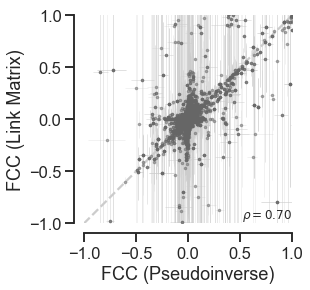

<IPython.core.display.Javascript object>

In [29]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

ax.set_aspect('equal')
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            marker='.', color='.4', zorder=3, alpha=0.5)
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            elinewidth=.5, color='.8', alpha=0.5, zorder=2)

ax.plot([-5, 5], [-5, 5], '--', color='.8', zorder=0)

ax.set_xlabel('FCC (Pseudoinverse)')
ax.set_ylabel('FCC (Link Matrix)')

ax.set_rasterization_zorder(4)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])


plt.tight_layout()
sns.despine(trim=True, offset=10)
ax.text(1, -1, '$\\rho = {:.2f}$'.format(
    pd.Series(r_med).corr(pd.Series(l_med))), ha='right', va='bottom', fontsize=12)

plt.savefig('A.niger_fcc_comparison.svg', dpi=300)

In [40]:
fcc_med = np.median(fccs, 0)
fcc_med = pd.DataFrame(fcc_med, columns=r_labels, index=r_labels)
fcc_med

,r1,r5a,r6,r7,r8,r9,r10,r12a,r13a,r14,...,r2818,r2819,r2820,r2821,r2847,BAPAT,HPDH,ALD6,3HPPt,EX_3hpp_e
r1,0.999173,-0.008667,0.003526,-0.000018,0.002342,0.007164,0.001794,0.001828,-0.003947,-0.001608,...,0.000213,-0.000063,0.000079,0.000589,0.000163,-0.001608,-0.003293,-0.000629,-0.002199,-0.000517
r5a,-0.019779,0.070588,-0.013977,-0.001157,-0.014821,-0.051517,-0.001342,-0.000742,-0.000228,0.001061,...,-0.000047,0.000068,-0.000119,-0.000068,0.000009,-0.000037,-0.000105,-0.000680,0.000068,-0.000021
r6,0.036189,-0.124832,0.024805,0.002047,0.026198,0.091163,0.002366,0.001306,0.000399,-0.001875,...,0.000084,-0.000122,0.000211,0.000124,-0.000013,0.000063,0.000185,0.001193,-0.000126,0.000035
r7,0.001345,-0.007868,0.007879,0.077131,0.383967,-0.031896,-0.168826,-0.100937,-0.049392,0.008960,...,-0.001729,-0.000608,0.000565,-0.002943,-0.000954,-0.011360,0.004944,-0.232307,0.007649,0.003354
r8,0.001525,-0.001592,0.024351,0.089880,0.947599,-0.046500,0.015701,0.008785,0.005651,-0.000036,...,0.000549,-0.000773,0.001157,-0.000595,0.000976,0.001556,-0.000938,0.025627,-0.001784,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BAPAT,-0.000247,0.002261,0.001050,-0.012745,0.006745,0.004058,0.067968,0.040380,0.019645,0.000639,...,-0.005879,-0.001730,-0.000009,-0.006085,0.006330,0.003656,0.012298,-0.008495,0.014008,0.023968
HPDH,-0.000241,0.003969,0.002340,-0.014336,0.007206,0.004130,0.100152,0.059735,0.028463,0.005648,...,-0.015498,-0.004169,-0.000583,-0.015567,0.013395,-0.013273,0.032481,-0.361064,0.039425,0.057150
ALD6,-0.000262,-0.001876,-0.001824,-0.008708,0.005228,0.005053,-0.008327,-0.003914,-0.001243,-0.010325,...,0.015685,0.004141,0.001214,0.014874,-0.009926,0.043233,-0.035681,0.813622,-0.045999,-0.052871
3HPPt,-0.000241,0.003969,0.002340,-0.014336,0.007206,0.004130,0.100152,0.059735,0.028463,0.005648,...,-0.015498,-0.004169,-0.000583,-0.015567,0.013395,-0.013273,0.032481,-0.361064,0.039425,0.057150


<IPython.core.display.Javascript object>

In [41]:
def corrwith(left, right, df=True):
    # demeaned data
    left_tiled = np.repeat(left.values[:, np.newaxis, :], right.shape[0], 1)
    right_tiled = np.repeat(right.values[np.newaxis, :, :], left.shape[0], 0)

    ldem = left_tiled - left_tiled.mean(-1)[:, :, np.newaxis]
    rdem = right_tiled - right_tiled.mean(-1)[:, :, np.newaxis]

    num = (ldem * rdem).sum(-1)

    dom = (left.shape[1] - 1) * left_tiled.std(-1) * right_tiled.std(-1)
    correl = num / dom

    if not df:
        return correl
    else:
        return pd.DataFrame(correl, index=left.index, columns=right.index)


corr_df = corrwith(e, v).T
corr_df

,r5a,r7,r8,r10,r12a,r13a,r14,r15,r16a,r17,...,r127,r243,r258,r259,r258m,PAND,r2142,r2143,r2144,BAPAT
r1,-0.501740,-0.443259,-0.443259,0.617495,-0.194865,0.199191,0.247948,0.018690,0.039706,-0.362464,...,-0.209148,-0.648739,-0.321830,-0.054397,0.288853,-0.709064,-0.587020,-0.587020,-0.587020,-0.463216
r5a,0.669909,0.475661,0.475661,-0.614526,0.376706,-0.194573,-0.131868,0.268197,0.155214,0.532652,...,0.165994,0.660376,0.348116,0.204758,-0.365199,0.848483,0.717450,0.717450,0.717450,0.652052
r6,0.505730,0.278024,0.278024,-0.317423,0.365699,-0.097075,0.039444,0.407034,0.262480,0.436096,...,0.046282,0.354920,0.205871,0.246778,-0.261413,0.571986,0.495337,0.495337,0.495337,0.515681
r7,0.581390,0.479116,0.479116,-0.653155,0.260417,-0.209607,-0.228137,0.065430,0.015850,0.434472,...,0.208706,0.690587,0.348685,0.102285,-0.328627,0.792443,0.660506,0.660506,0.660506,0.546726
r8,-0.501740,-0.443259,-0.443259,0.617495,-0.194865,0.199191,0.247948,0.018690,0.039706,-0.362464,...,-0.209148,-0.648739,-0.321830,-0.054397,0.288853,-0.709064,-0.587020,-0.587020,-0.587020,-0.463216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BAPAT,0.580996,0.450313,0.450313,-0.614032,0.321411,-0.196599,-0.142117,0.209807,0.143925,0.388813,...,0.219805,0.605768,0.270359,0.053090,-0.387904,0.761138,0.598646,0.598646,0.598646,0.503466
HPDH,0.595342,0.501190,0.501190,-0.686203,0.321286,-0.238739,-0.184697,0.180340,0.098687,0.433112,...,0.156024,0.692508,0.328050,0.172151,-0.347739,0.840399,0.694320,0.694320,0.694320,0.605690
ALD6,-0.368068,-0.500904,-0.500904,0.698185,-0.159896,0.326769,0.301937,0.054997,0.173451,-0.434505,...,0.236107,-0.773072,-0.447959,-0.672257,-0.024046,-0.810134,-0.817974,-0.817974,-0.817974,-0.805945
3HPPt,0.595342,0.501190,0.501190,-0.686203,0.321286,-0.238739,-0.184697,0.180340,0.098687,0.433112,...,0.156024,0.692508,0.328050,0.172151,-0.347739,0.840399,0.694320,0.694320,0.694320,0.605690


<IPython.core.display.Javascript object>

In [32]:
def random_corr_iterator():
    return corrwith(
        e.loc[:, np.random.permutation(e.columns)],
        v.loc[:, np.random.permutation(e.columns)],
        df=False,
    )

<IPython.core.display.Javascript object>

In [33]:
permuted_corr_mat = np.array([random_corr_iterator() for _ in tqdm(range(2000))])

100%|██████████| 2000/2000 [00:13<00:00, 143.81it/s]


<IPython.core.display.Javascript object>

In [43]:
import scipy
from scipy import cluster

z_scores = (corr_df - permuted_corr_mat.mean(0).T) / permuted_corr_mat.std(0).T
p_vals = 2 * z_scores.abs().apply(scipy.stats.norm.sf)


def sort_df(df):
    df = df.replace(np.inf, 10).replace(-np.inf, -10)
    sort_x = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df, "complete"))
    sort_y = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df.T, "complete"))

    return df.iloc[sort_x, sort_y]

<IPython.core.display.Javascript object>

In [39]:
corr_df

,r5a,r7,r8,r10,r12a,r13a,r14,r15,r16a,r17,...,r127,r243,r258,r259,r258m,PAND,r2142,r2143,r2144,BAPAT
r1,-0.501740,-0.443259,-0.443259,0.617495,-0.194865,0.199191,0.247948,0.018690,0.039706,-0.362464,...,-0.209148,-0.648739,-0.321830,-0.054397,0.288853,-0.709064,-0.587020,-0.587020,-0.587020,-0.463216
r5a,0.669909,0.475661,0.475661,-0.614526,0.376706,-0.194573,-0.131868,0.268197,0.155214,0.532652,...,0.165994,0.660376,0.348116,0.204758,-0.365199,0.848483,0.717450,0.717450,0.717450,0.652052
r6,0.505730,0.278024,0.278024,-0.317423,0.365699,-0.097075,0.039444,0.407034,0.262480,0.436096,...,0.046282,0.354920,0.205871,0.246778,-0.261413,0.571986,0.495337,0.495337,0.495337,0.515681
r7,0.581390,0.479116,0.479116,-0.653155,0.260417,-0.209607,-0.228137,0.065430,0.015850,0.434472,...,0.208706,0.690587,0.348685,0.102285,-0.328627,0.792443,0.660506,0.660506,0.660506,0.546726
r8,-0.501740,-0.443259,-0.443259,0.617495,-0.194865,0.199191,0.247948,0.018690,0.039706,-0.362464,...,-0.209148,-0.648739,-0.321830,-0.054397,0.288853,-0.709064,-0.587020,-0.587020,-0.587020,-0.463216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BAPAT,0.580996,0.450313,0.450313,-0.614032,0.321411,-0.196599,-0.142117,0.209807,0.143925,0.388813,...,0.219805,0.605768,0.270359,0.053090,-0.387904,0.761138,0.598646,0.598646,0.598646,0.503466
HPDH,0.595342,0.501190,0.501190,-0.686203,0.321286,-0.238739,-0.184697,0.180340,0.098687,0.433112,...,0.156024,0.692508,0.328050,0.172151,-0.347739,0.840399,0.694320,0.694320,0.694320,0.605690
ALD6,-0.368068,-0.500904,-0.500904,0.698185,-0.159896,0.326769,0.301937,0.054997,0.173451,-0.434505,...,0.236107,-0.773072,-0.447959,-0.672257,-0.024046,-0.810134,-0.817974,-0.817974,-0.817974,-0.805945
3HPPt,0.595342,0.501190,0.501190,-0.686203,0.321286,-0.238739,-0.184697,0.180340,0.098687,0.433112,...,0.156024,0.692508,0.328050,0.172151,-0.347739,0.840399,0.694320,0.694320,0.694320,0.605690


<IPython.core.display.Javascript object>

In [44]:
fccs_hpd = pm.hpd(fccs)
fcc_consistent = np.sign(fccs_hpd[:, :, 0]) == np.sign(fccs_hpd[:, :, 1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, columns=r_labels, index=r_labels)

sorted_corr_df = sort_df(corr_df)

fcc_med_measured = fcc_med.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index
)
fcc_consistent_measured = fcc_consistent_df.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index
)

ValueError: The condensed distance matrix must contain only finite values.

<IPython.core.display.Javascript object>

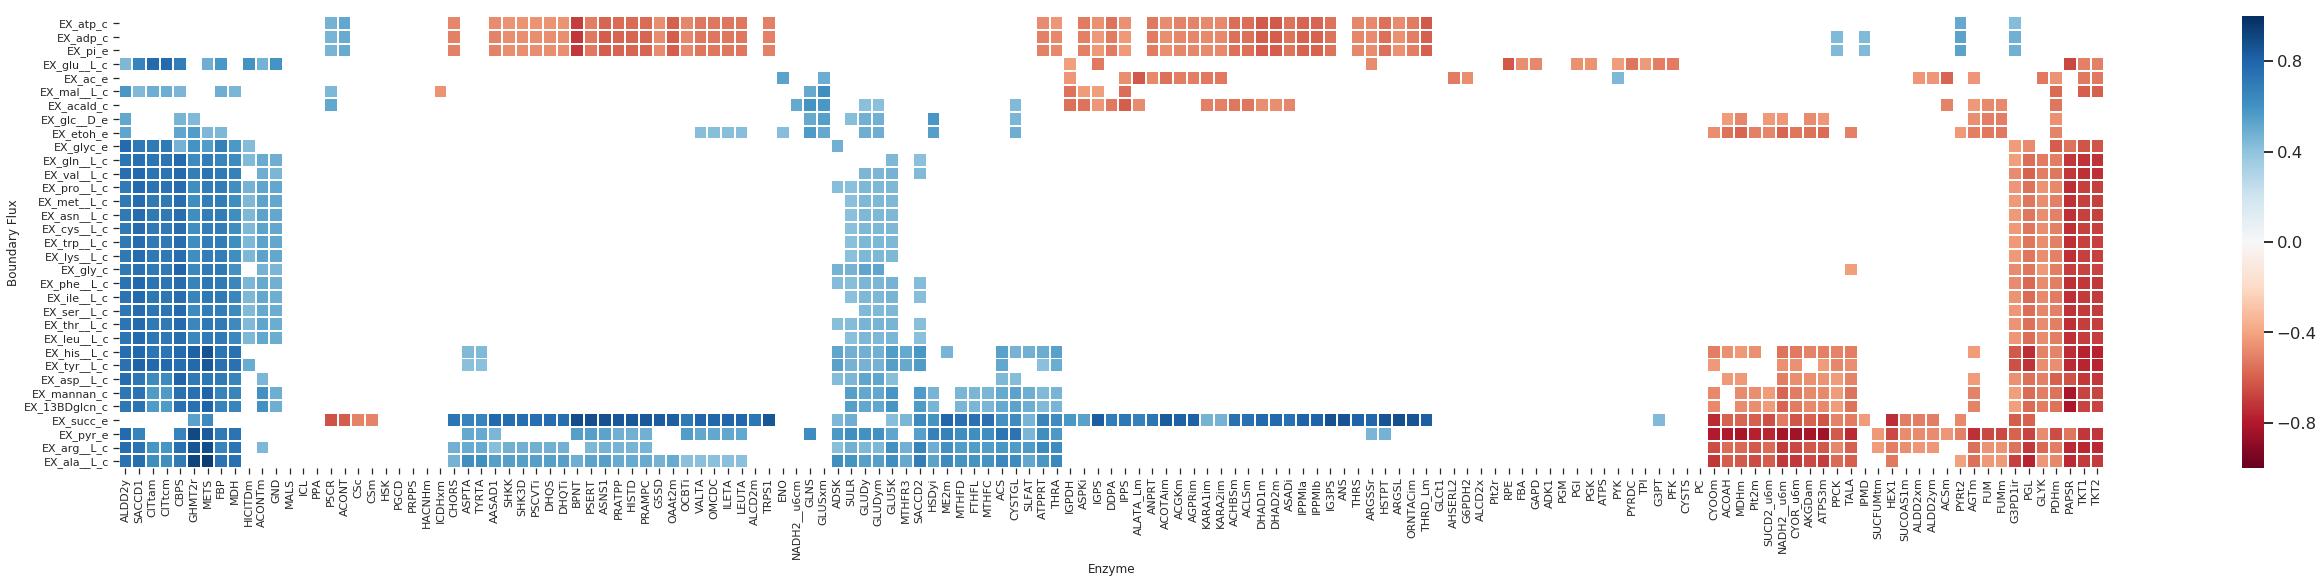

In [36]:
with sns.plotting_context('notebook'):
    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(sorted_corr_df[p_vals < 0.05].values, vmin=-1, vmax=1,
            cmap='RdBu', cbar=True, rasterized=True, lw=1)

_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('corr_heatmap_large_confident.svg', dpi=75)

NameError: name 'fcc_med_measured' is not defined

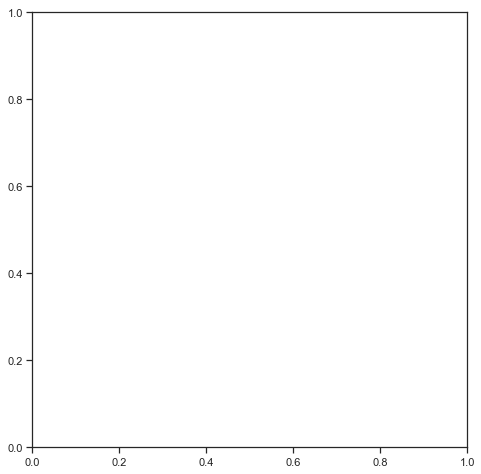

<IPython.core.display.Javascript object>

In [42]:
with sns.plotting_context("notebook"):

    fig = plt.figure(figsize=(40, 8))
    ax = fig.add_subplot(111, aspect="equal", adjustable="box")

sns.heatmap(
    fcc_med_measured[fcc_consistent_measured].values,
    center=0,
    robust=True,
    cmap="RdBu",
    cbar=True,
    rasterized=True,
    lw=1,
)

_ = ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_ = ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel("Enzyme")
ax.set_ylabel("Boundary Flux")

plt.tight_layout()
plt.savefig("fcc_heatmap_large.svg", dpi=75)